# Techniques for Global Explanation

## ANOVA analysis

Analysis of Variance (a.k.a. multi-way ANOVA) is a statistical test that
examines the importance of multiple independent variables (e.g., two or
more software metrics) on the outcome (e.g.,
defect-proneness) {cite}`fisher1925intraclass`. The significance of each
metric in a regression model is estimated from the calculation of the
Sum of Squares (SS)---i.e., the explained variance of the observations
with respect to their mean value. There are two commonly-used approaches
to calculate the Sum of Squares for ANOVA, namely, Type-I and Type-II.
We provide a description of the two types of ANOVA below.

**Type-I**, *one of the most commonly-used interpretation techniques and
the default interpretation technique for a logistic regression (`glm`)
model in R*, examines the importance of each metric in a sequential
order {cite}`chambers1992statistical`{cite}`fox2015applied`. In other words,
Type-I measures the improvement of the Residual Sum of Squares (RSS)
(i.e., the unexplained variance) when each metric is sequentially added
into the model. Hence, Type-I attributes as much variance as it can to
the first metric before attributing residual variance to the second
metric in the model specification. Thus, the importance (i.e., produced
ranking) of metrics is dependent on the ordering of metrics in the model
specification.

The calculation starts from the RSS of the preliminary model
($y \sim 1$), i.e., a null model that is fitted without any software
metrics. We then compute the RSS of the first metric by fitting a
regression model with the first metric ($y \sim m_1$). Thus, the
importance of the first metric ($m_1$) is the improvement between the
unexplained variances (RSS) of the preliminary model and the model that
is constructed by the first metric.

$$\mathrm{SS}(m_1) = \mathrm{RSS}(\mathrm{Model}_\mathrm{null})-\mathrm{RSS}(m_1)$$

Similar to the computation of the importance of the first metric, the
importance of the remaining metrics is computed using the following
equation.

$$\mathrm{SS}(m_i) = \mathrm{RSS}(\mathrm{m_1 + ... + m_{i-1}})-\mathrm{RSS}(m_1 + ... + m_i)$$

**Type II**, an enhancement to the ANOVA Type-I, examines the importance
of each metric in a hierarchical nature, i.e., the ordering of metrics
is rearranged for each
examination {cite}`chambers1992statistical`{cite}`fox2015applied`. The importance
of metrics (Type-II) measures the improvement of the Residual Sum of
Squares (RSS) (i.e., the unexplained variance) when adding a metric
under examination to the model after the other metrics. In other words,
the importance of metrics (Type-II) is equivalent to a Type-I where a
metric under examination appears at the last position of the model. The
intuition is that the Type-II is evaluated after all of the other
metrics have been accounted for. The importance of each metric (i.e.,
SS($m_e$)) measures the improvement of the RSS of the model that is
constructed by adding only the other metrics except for the metric under
examination, and the RSS of the model that is constructed by adding the
other metrics where the metric under examination appears at the last
position of the model. For example, given a set of $M$ metrics, and
$e,i,j\in[1,M]$, the importance of each metric $m_e$ can be explained as
follows:

$$\mathrm{SS}(m_e) = \mathrm{RSS}(m_i + ... + m_{j})-\mathrm{RSS}(m_i + ... + m_{j} + m_e)$$

where $m_e$ is the metric under examination and $m_i + ... + m_{j}$ is a
set of the other metrics except the metric under examination.

### A tutorial of ANOVA analysis

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:ylabel='Features'>

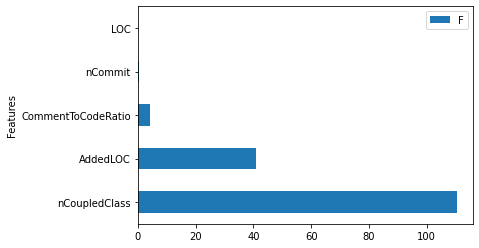

In [2]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Regression)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression

# Import for ANOVA (Regression)
import statsmodels.api as sm


train_dataset = pd.read_csv(("../../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

## Construct a black-box model (Regression)

# regression (ols)
model_formula = outcome + ' ~ ' + ' + '.join(features)
regression_model = ols(model_formula, data = training_data)
regression_model_fit = regression_model.fit()


# compute an ANOVA Type-II table
aov_table = sm.stats.anova_lm(regression_model_fit, 
                              typ=2)
aov_table.sort_values(by = 'sum_sq', ascending = False, inplace = True)

# visualize an ANOVA Type-II table
aov_table['Features'] = aov_table.index
aov_table.iloc[1:,:].plot(kind = 'barh', y = 'F', x = 'Features') # remove the residual

## Variable Importance analysis

Variable importance (a.k.a. VarImp) is an approach to examine the
importance of software metrics for random forest models. There are two
commonly-used calculation approaches of variable importance scores,
namely, Gini Importance and Permutation Importance, which we describe
below.

**Gini Importance (a.k.a. MeanDecreaseGini)** determines the importance
of metrics from the decrease of the Gini Index, i.e., the distinguishing
power for the defective class due to a given
metric {cite}`breiman2001random`. We start from a random
forest model that is constructed using the original dataset with
multiple trees, where each tree is constructed using a bootstrap sample.
For each tree, a parent node (i.e., $G_{\mathrm{Parent}}$) is split by
the best cut-point into two descendent nodes (i.e.,
$G_{\mathrm{Desc.1}}$ and $G_{\mathrm{Desc.2}}$). The calculation of the
Gini Importance of each metric is made up of 2 steps:

*(Step 1) Compute the DecreaseGini for all of the trees in the random
forest model.* The DecreaseGini is the improvement of the ability to
distinguish between two classes across parent and its descendent nodes.
We compute the DecreaseGini using the following equation:

$$\mathrm{DecreaseGini}(m_i) = I_{m_i} = G_{\mathrm{Parent}} - G_{\mathrm{Desc.1}} - G_{\mathrm{Desc.2}}$$

where $G$ is the Gini Index, i.e., the distinguishing power of defective
class for a given metric. The Gini Index is computed using the following
equation: $G = \sum_{i=1}^{N_{\mathrm{Class}}}p_i(1-p_i)$, where
$N_{\mathrm{Class}}$ is the number of classes and $p_i$ is the
proportion of Class$_i$.

*(Step 2) Compute the MeanDecreaseGini measure.* Finally, the importance
of each metric (i.e., MeanDecreaseGini) is the average of the
DecreaseGini values from all of the splits of that metric across all the
trees in the random forest model.

In this paper, we consider both the scaled and non-scaled importance
scores for the Gini Importance.

**Permutation Importance (a.k.a. MeanDecreaseAccuracy)** determines the
importance of metrics from the decrease of the accuracy (i.e., the
misclassification rate) when the values of a given metric are randomly
permuted {cite}`breiman2001random`. Similar to
MeanDecreaseGini, we start from a random forest model that is
constructed using an original dataset with multiple trees, where each
tree is constructed using an out-of-sample bootstrap. The calculation of
the Permutation Importance is made up of 2 steps:

*(Step 1) Compute the DecreaseAccuracy of each tree in the random forest
model.* The DecreaseAccuracy is the decrease of the accuracy (i.e.,
misclassification rate) between a model that is tested using the
original out-of-bag testing samples and a model that is tested using
permuted out-of-bag testing samples, i.e., a dataset with one metric
permuted, while all other metrics are unchanged).

*(Step 2) Compute the MeanDecreaseAccuracy measure.* Finally, the
importance of each metric (i.e., MeanDecreaseAccuracy) is the average of
the DecreaseAccuracy values across all of the trees in the random forest
model.

## A tutorial of Variable Importance Analysis

<AxesSubplot:ylabel='Features'>

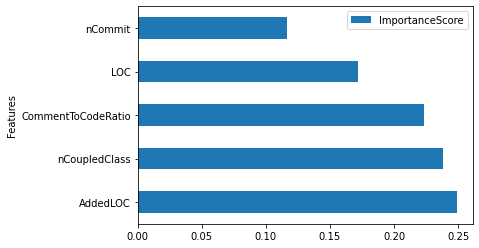

In [3]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier

train_dataset = pd.read_csv(("../../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

## Construct a black-box model (Random Forests)

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

# get VarImp score from the rf_model
feature_importances = pd.DataFrame({'Features': features,
             'ImportanceScore': rf_model.feature_importances_})
feature_importances.sort_values(by = 'ImportanceScore', ascending = False, inplace = True)

# visualize VarImp
feature_importances.plot(kind = 'barh', y = 'ImportanceScore', x = 'Features') # remove the residual

## Partial Dependence Plot (PDP)

**Partial Dependence Plot (PDP)** {cite}`friedman2001greedy` is a
model-agnostic technique to generate model explanations for any
classification models. Unlike visual explanations generated by ANOVA and
VarImp that show only the importance of all features, visual
explanations generated by PDP illustrate the marginal effect that one or
two features have on the predicted outcome of a classification model.

### A tutorial of Partial Dependence Plot (PDP)

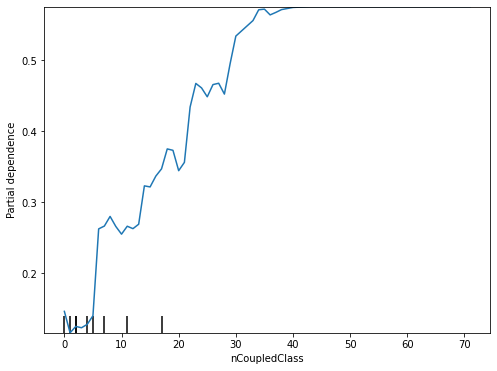

In [4]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier

# Import for Partial Dependence Plot (PDP)
import subprocess
import sys
import importlib
import sklearn
from sklearn.inspection import plot_partial_dependence # new version
import matplotlib.pyplot as plt


train_dataset = pd.read_csv(("../../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

## Construct a black-box model (Random Forests)

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylabel(ylabel = '', fontsize = 24)
ax.set_xlabel(xlabel = '', fontsize = 24)

# a visual example of PDP for the ActiveDevelopers (features[2])
plot_partial_dependence(estimator = rf_model, 
                        X = X_train, 
                        features = [2], 
                        feature_names = features, 
                        ax = ax)

## Decision Tree/Decision Rules

**Decision Tree** or Decision Rule is a technique to generate tree-based
model explanations. A decision tree is constructed in a top-down
direction from a root node. Then, a decision tree partitions the data
into subsets of similar instances (homogeneous). Typically, an entropy
or an information gain score are used to calculate the homogeneity of
among instances. Finally, the constructed decision tree can be converted
into a set of if-then-else decision rules.

### A tutorial of Decision Tree/Decision Rules

In [5]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Decision Rules/Decision Trees
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import collections

train_dataset = pd.read_csv(("../../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)



# construct a decision rules/decision trees model
dt_model = tree.DecisionTreeClassifier(random_state=1234, max_depth=2)
dt_model.fit(X_train, y_train)  
dt_text = tree.export_text(dt_model, 
                          feature_names = features)
  
# visualize 
print(dt_text)

|--- nCoupledClass <= 5.50
|   |--- AddedLOC <= 145.50
|   |   |--- class: 0
|   |--- AddedLOC >  145.50
|   |   |--- class: 0
|--- nCoupledClass >  5.50
|   |--- AddedLOC <= 113.00
|   |   |--- class: 0
|   |--- AddedLOC >  113.00
|   |   |--- class: 1

